In [1]:
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
import os

In [3]:
os.listdir('data')

['spec', 'super-raw', 'raw']

In [4]:
import numpy as np

In [5]:
x = np.load('data/spec/The Airborne Toxic Event-The Airborne Toxic Event Deluxe Edition-Happiness Is Overrated.mp3 - 107 sec.npy')

In [6]:
x

array([[  5.10694777e-07,   1.10282666e-06,   8.77621656e-07, ...,
          1.83597571e-07,   1.76248167e-05,   4.24043893e-06],
       [  9.08853106e-07,   2.40361369e-06,   1.43610808e-06, ...,
          1.34090250e-07,   3.23502642e-05,   6.28688850e-06],
       [  1.45927754e-06,   4.09228860e-06,   2.21396286e-06, ...,
          9.36392313e-08,   5.24146331e-05,   9.10984876e-06],
       ..., 
       [  6.94744062e-06,   1.33959007e-06,   1.39344060e-06, ...,
          1.05777076e-05,   6.23164437e-06,   4.16239555e-06],
       [  6.14303373e-06,   1.69865827e-06,   1.73036971e-06, ...,
          1.27627823e-05,   4.32768057e-06,   4.48100764e-06],
       [  5.30756535e-06,   2.09302689e-06,   1.99053286e-06, ...,
          1.48864400e-05,   2.88151596e-06,   4.90735290e-06]])

In [7]:
x.shape

(184, 1574)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
spec_dir = 'data/spec'
spectrograms = [os.path.join(spec_dir, f) for f in os.listdir(spec_dir)]

In [10]:
import random

In [11]:
from sklearn.preprocessing import maxabs_scale 

In [12]:
def load(f):
    return maxabs_scale(np.load(f)).transpose()[:256,:]

data/spec/Deep Purple-The Very Best of Deep Purple Rhino-Kentucky Woman Single Version.mp3 - 64 sec.npy


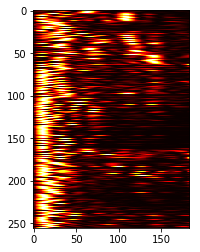

In [13]:
f = random.choice(spectrograms)
print(f)
x = load(f)
plt.imshow(x,  cmap='hot', interpolation='nearest')

In [82]:
# winner .0300 at 19 epochs
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPool1D, UpSampling1D, AveragePooling1D
model = Sequential([
    Conv1D(300, 64, padding='same', activation='relu', input_shape=(256, 184)),
    AveragePooling1D(2, padding='same'),
    Conv1D(200, 64, padding='same', activation='relu'),
    AveragePooling1D(2, padding='same'),
    Conv1D(150, 32, padding='same', activation='relu'),
    AveragePooling1D(2, padding='same'),
    Conv1D(128, 32, padding='valid', activation='sigmoid'),
    UpSampling1D(8),
    Conv1D(128, 4, padding='same', activation='relu'),
    UpSampling1D(4),
    Conv1D(150, 32, padding='same', activation='relu'),
    UpSampling1D(2),
    Conv1D(200, 64, padding='same', activation='relu'),
    UpSampling1D(2),
    Conv1D(300, 64, padding='same', activation='relu', input_shape=(256, 184)),
    UpSampling1D(2),
    Conv1D(184, 1, activation='sigmoid')
])

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 128, 300)          7121100   
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 128, 200)          3840200   
_________________________________________________________________
average_pooling1d_23 (Averag (None, 64, 200)           0         
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 64, 150)           960150    
_________________________________________________________________
average_pooling1d_24 (Averag (None, 32, 150)           0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 1, 128)            614528    
_________________________________________________________________
up_sampling1d_52 (UpSampling (None, 8, 128)            0         
__________

# 1,032,990,720

In [46]:
model.compile(optimizer='adadelta', loss='mean_squared_error')

In [47]:
import numpy as np
def data_gen(files, batch_size):
    while True:
        np.random.shuffle(files)
        X = np.zeros((batch_size, 256, 184))
        for i, f in enumerate(files):
            i = i % batch_size
            X[i,:] = load(f)
            if i == batch_size - 1:
                yield X, X
                X = np.zeros((batch_size, 256, 184))

In [48]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, monitor='loss', verbose=1)

In [62]:
# .0088 @ 10 epochs
epochs = 60
batch_size = 30
steps = len(spectrograms) // batch_size
gen = data_gen(spectrograms, batch_size)
model.fit_generator(gen, steps_per_epoch=steps, epochs=epochs, callbacks=[early_stop])

Epoch 1/60
731/731 [==============================] - 243s 333ms/step - loss: 0.0295
Epoch 2/60
731/731 [==============================] - 245s 335ms/step - loss: 0.0294
Epoch 3/60
731/731 [==============================] - 244s 334ms/step - loss: 0.0293
Epoch 4/60
731/731 [==============================] - 241s 330ms/step - loss: 0.0293
Epoch 5/60
731/731 [==============================] - 241s 330ms/step - loss: 0.0292
Epoch 6/60
731/731 [==============================] - 241s 329ms/step - loss: 0.0292
Epoch 7/60
731/731 [==============================] - 243s 333ms/step - loss: 0.0291
Epoch 8/60
731/731 [==============================] - 244s 333ms/step - loss: 0.0290
Epoch 9/60
731/731 [==============================] - 243s 333ms/step - loss: 0.0290
Epoch 10/60
731/731 [==============================] - 243s 332ms/step - loss: 0.0289
Epoch 11/60
731/731 [==============================] - 243s 333ms/step - loss: 0.0289
Epoch 12/60
731/731 [==============================] - 241s 330

KeyboardInterrupt: 

In [ ]:
K.eval(model.optimizer.lr)

data/spec/Beautiful Eulogy-Satelilite Kite-Hello From Portland.mp3 - 70 sec.npy


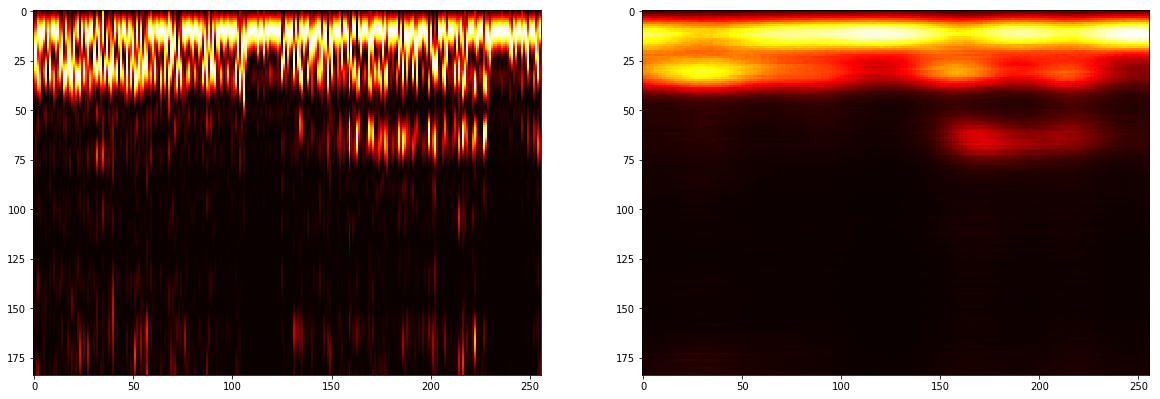

In [68]:
file = random.choice(spectrograms)
print(file)
x = load(file)
x_test = x.reshape(1, 256, 184)
pred = model.predict(x_test)
f, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(x.transpose(),  cmap='hot', interpolation='nearest')
ax[1].imshow(pred[0].transpose(),  cmap='hot', interpolation='nearest')

In [69]:
raise Exception
model.save('autoencoder.h5')

# test

In [57]:
def batcher(files, batch_size):
    np.random.shuffle(files)
    X = np.zeros((batch_size, 256, 184))
    for i, f in enumerate(files):
        i = i % batch_size
        X[i,:] = load(f)
        if i == batch_size - 1:
            yield X
            X = np.zeros((batch_size, 256, 184))

In [60]:
b = next(batcher(spectrograms, len(spectrograms)))

KeyboardInterrupt: 

In [59]:
b.shape

<generator object batcher at 0x7fd07ed0b1a8>